In [ ]:
import sys
sys.path.extend(['/users/students/r0749898/thesis/'])

In [2]:
from datasets.SHHS_dataset_timeonly import SHHS_dataset_1, EEGdataModule

from models.simclr_model import SimCLR
from models.supervised_model import SupervisedModel
import torch
import matplotlib.pyplot as plt
import numpy as np
from argparse import Namespace
from copy import deepcopy
from utils.helper_functions import load_model, SimCLRdataModule

## Define dataset: 10 patients for training, 5 for validation and 30 for testing


In [3]:
data_args = {
  "DATA_PATH": "/esat/biomeddata/SHHS_Dataset/no_backup/",
  "data_split": [2, 1],
  "first_patient": 15,
  "num_patients_train": 15,
  "num_patients_test": 30,
  "batch_size": 64,
  "num_workers": 12
}

dm = EEGdataModule(**data_args)  # Load datamodule
dm.setup()

In [4]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print(device)

cuda:0


## Run data through the pretrained SimCLR encoder to get the representations
- The SimCLR model was pretrained on 100 patients (+50 for validation)

In [5]:
encoder_path = "../trained_models/cnn_simclr01.ckpt"
pretrained_model = load_model(SimCLR, encoder_path)  # Load pretrained simclr model
simclr_dm = SimCLRdataModule(pretrained_model, dm, data_args['batch_size'], data_args['num_workers'], device)

/users/students/r0749898/miniconda3/envs/newthesisenv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
  rank_zero_warn(
/users/students/r0749898/miniconda3/envs/newthesisenv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.
  rank_zero_warn(


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/452 [00:00<?, ?it/s]

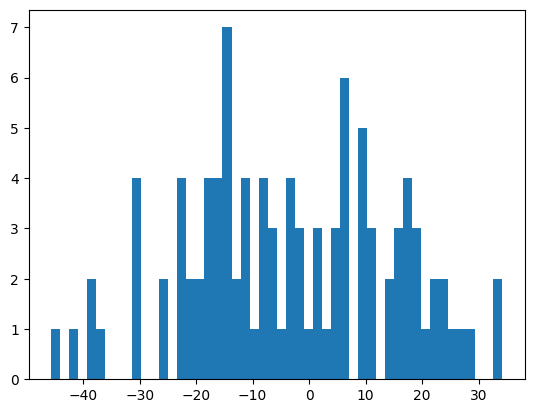

In [6]:
## Analyse the features: histogram and t-SNE plot
feature = next(iter(simclr_dm.train_dataloader()))[0][0]
plt.hist(np.asarray(feature), bins=50)
plt.show()

## Train a logistic classifier on top


In [7]:
logistic_args = {
  "MODEL_TYPE": "SupervisedModel",
  "save_name": "logistic_on_simclr",
  "DATA_PATH": data_args['DATA_PATH'],
  "CHECKPOINT_PATH": "checkpoints",

  "encoder": "None",
  "encoder_hparams": {},

  "classifier": "logistic",
  "classifier_hparams":{
      "input_dim": 100
  },
  "data_hparams": data_args,

  "trainer_hparams":{
    "max_epochs": 15
  },
  "optim_hparams": {
    "lr": 1e-3,
    "weight_decay": 1e-4
  }
}
from trainers.train_supervised import train_supervised
logistic_model, logistic_res = train_supervised(Namespace(**logistic_args), device=device, dm=simclr_dm)
print(logistic_res)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/users/students/r0749898/miniconda3/envs/newthesisenv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'classifier' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['classifier'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | encoder     | Identity         | 0     
1 | classifier  | Linear           | 505   
2 | net         | Sequential       | 505   
3 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
505       Trainable params
0         Non-trainable params
505       Total params
0.002     Total estimated model param

Sanity Checking: 0it [00:00, ?it/s]

/users/students/r0749898/miniconda3/envs/newthesisenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/users/students/r0749898/miniconda3/envs/newthesisenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

{'test': 0.702028214931488, 'val': 0.7538461685180664}


## Train a supervised model with the same dataset for comparison


In [16]:
supervised_args = {
  "MODEL_TYPE": "SupervisedModel",
  "save_name": "supervised_simclr",
  "DATA_PATH": data_args['DATA_PATH'],
  "CHECKPOINT_PATH": "checkpoints",

  "encoder": "CNN_head",
  "encoder_hparams": {
    "conv_filters": [32, 64, 64],
    "representation_dim": 100
  },

  "classifier": "logistic",
  "classifier_hparams":{
      "input_dim": 100
  },
  "data_hparams": data_args,

  "trainer_hparams":{
    "max_epochs": 30
  },
  "optim_hparams": {
    "lr": 1e-4,
    "weight_decay": 1e-4
  }
}
sup_model, sup_res = train_supervised(Namespace(**supervised_args), device, dm=dm)
print(sup_res)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | encoder     | CNN_head         | 2.4 M 
1 | classifier  | Linear           | 505   
2 | net         | Sequential       | 2.4 M 
3 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.678     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

{'test': 0.6837186813354492, 'val': 0.7257435917854309}


## Finetuned supervised model

In [11]:
finetune_args = {
  "MODEL_TYPE": "SupervisedModel",
  "save_name": "finetuned_simclr",
  "DATA_PATH": data_args['DATA_PATH'],
  "CHECKPOINT_PATH": "checkpoints",

  "encoder": "CNN_head",
  "encoder_hparams": {
    "conv_filters": [32, 64, 64],
    "representation_dim": 100
  },

  "classifier": "logistic",
  "classifier_hparams":{
      "input_dim": 100
  },
  "data_hparams": data_args,

  "trainer_hparams":{
    "max_epochs": 30
  },
  "optim_hparams": {
    "lr": 1e-5,
    "weight_decay": 1e-5
  }
}
pretrained_encoder = type(pretrained_model.f)(**finetune_args['encoder_hparams'])
pretrained_encoder.load_state_dict(pretrained_model.f.state_dict())
fine_tuned_model, fine_tuned_res = train_supervised(Namespace(**finetune_args), device, dm=dm, pretrained_encoder=pretrained_encoder)
print(fine_tuned_res)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | net         | Sequential       | 2.4 M 
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.678     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

{'test': 0.6875259876251221, 'val': 0.7440000176429749}


In [15]:
finetune_logistic_args = {
  "MODEL_TYPE": "SupervisedModel",
  "save_name": "finetuned_simclr",
  "DATA_PATH": data_args['DATA_PATH'],
  "CHECKPOINT_PATH": "checkpoints",

  "encoder": "CNN_head",
  "encoder_hparams": {
    "conv_filters": [32, 64, 64],
    "representation_dim": 100
  },

  "classifier": "logistic",
  "classifier_hparams":{
      "input_dim": 100
  },
  "data_hparams": data_args,

  "trainer_hparams":{
    "max_epochs": 50
  },
  "optim_hparams": {
    "lr": 1e-6,
    "weight_decay": 0
  }
}
pretrained_encoder = type(pretrained_model.f)(**finetune_logistic_args['encoder_hparams'])
pretrained_classifier = type(logistic_model.classifier)(finetune_logistic_args['classifier_hparams']['input_dim'], 5)
pretrained_classifier.load_state_dict(logistic_model.classifier.state_dict())
pretrained_encoder.load_state_dict(pretrained_model.f.state_dict())
fully_tuned_model, fully_tuned_res = train_supervised(Namespace(**finetune_logistic_args), device, dm=dm, pretrained_encoder=pretrained_encoder, pretrained_classifier=pretrained_classifier)
print(fully_tuned_res)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | encoder     | CNN_head         | 2.4 M 
1 | classifier  | Linear           | 505   
2 | net         | Sequential       | 2.4 M 
3 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.678     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

{'test': 0.7168766260147095, 'val': 0.7659487128257751}


In [13]:
print(fully_tuned_res)

{'test': 0.7162536382675171, 'val': 0.7677948474884033}
